# Imports

In [1]:

from __future__ import division
import numpy as np
import sys
from sys import platform as sys_pf
if sys_pf == 'Darwin':
    import matplotlib
    matplotlib.use("TkAgg")

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import animation
import math
import ar
from sklearn.preprocessing import normalize
import pandas as pd
from pandas import Series, DataFrame, Panel
import seaborn as sns


# Helper Functions

In [2]:
def plot_trajectory_2D(n, is_one, x, y,cxx=None,cyy=None, step=1, scatter_plot=False):
    """************************************************************** 
    n:        no_of_frames to plot
    is_one:   True:  Single object's trajectory
              False: Multiple object's trajectories
    step:     step_size
    x,y:      Coordinates to plot
    **************************************************************"""
    if is_one:
        traj_points = 1
        T = np.linspace(0,1,x.shape[0])

    else : 
        traj_points = x.shape[0]
        T = np.linspace(0,1,traj_points)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    s = step
    plt.gca().invert_yaxis()
    for index in range(traj_points): 
        for i in range(0,n-s,s):
            if is_one : 
                ax.plot(x[i:i+s+1],y[i:i+s+1],linewidth=3)
            else : 
                
                cx = x[index]
                cy = y[index]
                if (scatter_plot):
                    ax.scatter(cx[i:i+s+1],cy[i:i+s+1],color=(0.0,0.0,T[index]))
                else:
                    ax.plot(cx[i:i+s+1],cy[i:i+s+1],linewidth=3,color=(0.0,0.0,T[index]))
    if (cxx is not None):
        n=cxx.shape[1]
        for index in range(traj_points): 
            for i in range(0,n-s,s):
                if is_one : 
                    ax.plot(x[i:i+s+1],y[i:i+s+1],linewidth=3)
                else : 

                    cx = cxx[index]
                    cy = cyy[index]
                    if (scatter_plot):
                        ax.scatter(cx[i:i+s+1],cy[i:i+s+1],color=(T[index],0.0,0.0))
                    else:
                        ax.plot(cx[i:i+s+1],cy[i:i+s+1],linewidth=3,color=(0.0,0.0,T[index]))

    
    plt.show()

In [3]:
def plot_trajectory_3D(n, is_one, x, y, z, step=1):
    """************************************************************** 
    n:        no_of_frames to plot
    is_one:   True:  Single object's trajectory
              False: Multiple object's trajectories
    step:     step_size
    x,y:      Coordinates to plot
    **************************************************************"""
    
    fig = plt.figure() 
    ax = fig.add_subplot(111, projection='3d')
    plt.gca().invert_yaxis()
    

    if is_one :
        traj_points = 1
        T = np.linspace(0,1,x.shape[0])

    else : 
        traj_points = x.shape[0]
        T = np.linspace(0,1,traj_points)

    s = step
    for index in range(traj_points):
        for j in range(0, n-s, s):
            if is_one :             
                ax.plot(x[j:j+s+1],y[j:j+s+1],z[j:j+s+1],linewidth=2)
            else : 
                cx = x[index]
                cy = y[index]
                cz = z
                ax.plot(cx[j:j+s+1],cy[j:j+s+1],cz[j:j+s+1],linewidth=2,color=(0.0,0.0,T[index]))


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()

In [4]:
def predict(X, A,order=2,predict_states=1,guided = True):
    
    # This is somewhat tricky. For abitrary order, we need to
    # come up with an expression for:
    #
    # Xrecon = SUM_OF_PREVIOUS_TERMS
    #
    # where SUM_OF_PREVIOUS_TERMS is constructed in a loop over "order"
    # previous elements in the data, multiplying each element by the
    # corresponding transition matrix/coefficient. Then that sum needs to be
    # but a single element in a larger array that has a correspondence to
    # the original X.
    Xnext = np.zeros((X.shape[0],X.shape[1]+predict_states))
    Xnext[:, :order] = X[:, :order]
    
    
    #Assuming np.size(X, axis = 1) = order
    for p in range(np.size(X, axis = 1),np.size(X, axis = 1)+predict_states):
        for j in range(0, order):
            # The second argument to np.dot() is a ternary statement, conditioning
            # on the "guided" boolean passed into this method: do we use the actual
            # data in estimating the next point, or previously-esimated data?
            
            Xnext[:, p] += np.dot(A[j], Xnext[:, p - j - 1] if guided else Xnext[:, p - j -1])
    
    
    orig_X = Xnext[:,:order]
    next_X = Xnext[:,order:]
    Xnext_mean = Xnext - np.mean(Xnext, axis = 0)
    return orig_X, next_X, Xnext, Xnext_mean
    

# Normal Cells

### Read inputs

In [5]:
normal_cells_files = [
        '/media/narita/Data/Neutrophils/fps_20_frames/1_07052016_Phagocytosis/final' \
                      '/tracking/organized_kalman_output_center_coords.npy',
        '/media/narita/Data/Neutrophils/fps_20_frames/5_07072016_Phagocytosis_DMSO/final' \
                      '/tracking/organized_kalman_output_center_coords.npy'


]

all_normal_cells = []
for i in range(len(normal_cells_files)):
    normal_input = np.load(normal_cells_files[i])
    all_normal_cells.insert(i,normal_input)

all_normal_cells = np.vstack(all_normal_cells) 


### Trajectory Plots

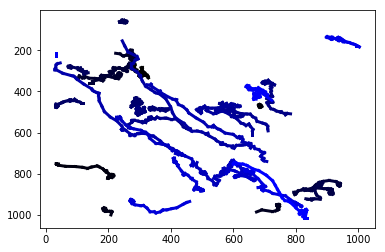

In [6]:
#%matplotlib notebook
is_one = False
plot_trajectory_2D(all_normal_cells.shape[1],is_one,all_normal_cells[:,:,0],all_normal_cells[:,:,1])


### AR

#### Normalize Inputs

In [7]:
all_normal_cells_copy = all_normal_cells.copy()
all_normal_cells_copy = np.transpose(all_normal_cells_copy,(1,0,2))
all_normal_cells_copy = all_normal_cells_copy.reshape(all_normal_cells_copy.shape[0],all_normal_cells_copy.shape[1]*all_normal_cells_copy.shape[2])

all_normal_cells_norm,normal_norms = normalize(all_normal_cells_copy,axis=0,return_norm=True)


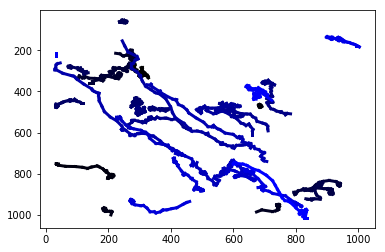

In [8]:
# If needed, plot again
recon = all_normal_cells_norm*normal_norms
recon = recon.reshape(all_normal_cells_copy.shape[0],int(all_normal_cells_copy.shape[1]/2),2)
recon = np.transpose(recon,(1,0,2))
plot_trajectory_2D(recon.shape[1],False,recon[:,:,0],recon[:,:,1])



#### State Space reduction - PCA

In [9]:
pca_components = 9
ar_order = 2
normal_X,normal_C,normal_S,normal_U = ar.state_space(all_normal_cells_norm.T,pca_components)


#### Variance of components

[81.919517436753878, 9.1471980015993211, 4.0167291380492856, 1.3339180146231466, 1.0453311968644323, 0.89452301935733591, 0.60424232894669039, 0.56492610460147574, 0.47361475920443852]


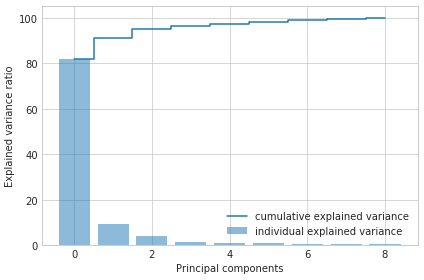

In [10]:
tot = sum(normal_S)
var_exp = [(i / tot) * 100 for i in sorted(normal_S, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print ((var_exp))

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

#### Plotting components

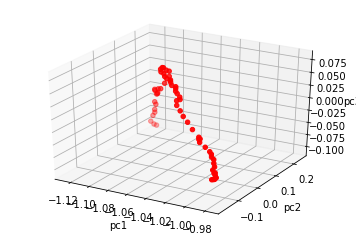

In [11]:
# 3D Plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_X[0,:], normal_X[1,:], normal_X[2,:],  c='r', marker='o')
ax.set_xlabel('pc1');ax.set_ylabel('pc2');ax.set_zlabel('pc3');

plt.show()

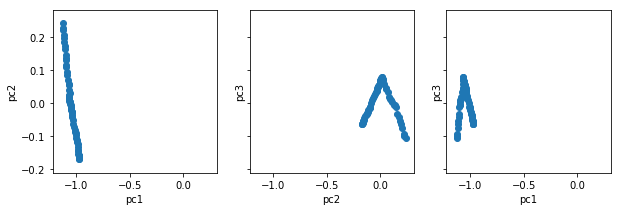

In [12]:
#2D Plot
%matplotlib inline

fig, ax = plt.subplots(1,3, sharey=True, sharex= True, figsize=(10,3))
ax[0].scatter(normal_X[0,:],normal_X[1,:]);ax[0].set_xlabel('pc1');ax[0].set_ylabel('pc2')
ax[1].scatter(normal_X[1,:],normal_X[2,:]);ax[1].set_xlabel('pc2');ax[1].set_ylabel('pc3')
ax[2].scatter(normal_X[0,:],normal_X[2,:]);ax[2].set_xlabel('pc1');ax[2].set_ylabel('pc3')


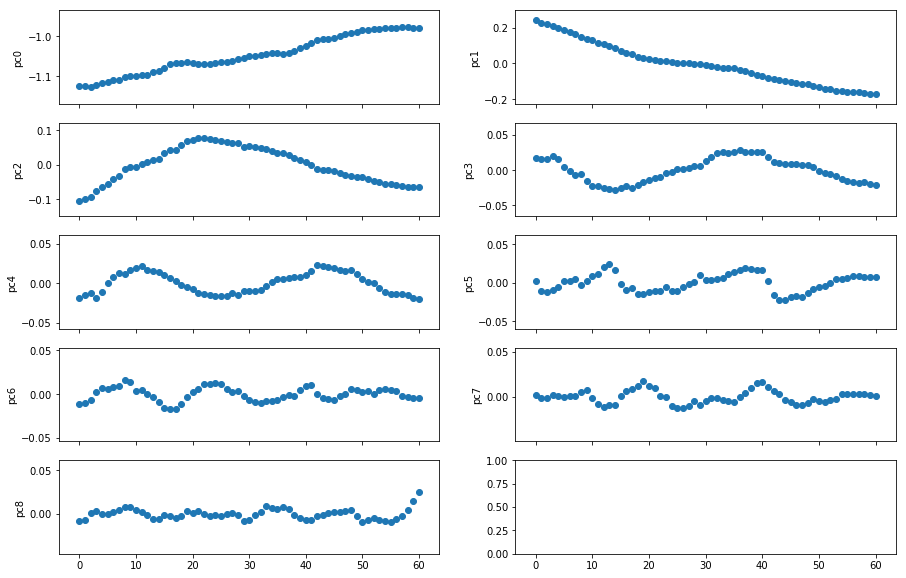

In [13]:
#2D Plot
%matplotlib inline

rows = int((pca_components/2)+(pca_components%2))
cols = 2
fig, ax = plt.subplots(rows,cols,sharex= True, figsize=(15,10))
for i in range(pca_components):
    if (i < (pca_components)):
        r = int(i/2)
        c = int(i%2)
        ax[r,c].scatter(range(len(normal_X[i,:])),normal_X[i,:]);ax[r,c].set_ylabel('pc'+str(i))


#### AR Train

In [14]:
normal_X_train = normal_X[:,:]
#X_test = X[:,50:]

Feature Vector:
[[[ 1.28034422 -0.16645182 -0.12960317 -0.0738095  -0.15815494  0.14297649
    0.04667415 -0.02484687  0.16217092]
  [ 0.39336603  0.79817042  0.0304495  -0.00375472  0.08327801 -0.06681592
    0.10206878 -0.32588102  0.17166386]
  [-0.56236922  0.49480256  1.0983895  -0.3221513   0.03592089 -0.13096849
   -0.07406373  0.20618192 -0.0721131 ]
  [-0.46554232  0.25333437 -0.17829113  1.23763416  0.02799046 -0.1626791
   -0.14487714  0.04838612 -0.12372804]
  [ 0.89620976 -0.03307688  0.321668   -0.14719856  0.8236729   0.35546432
   -0.11473026 -0.30811254  0.32017234]
  [-0.22563262 -0.00393893  0.43024902  0.2852681   0.13058795  1.1142934
   -0.07769399  0.02138108 -0.07715816]
  [-0.42115143  0.00911664 -0.16805588  0.26795064 -0.00261108 -0.01651175
    1.04457748  0.3151513  -0.09226249]
  [-0.36808154  0.17604138  0.03405081 -0.40348911  0.07823183 -0.23355547
    0.32381107  1.10926361 -0.24051059]
  [ 0.03306118 -0.02974307  0.07560809  0.09587082  0.16262706 -0.

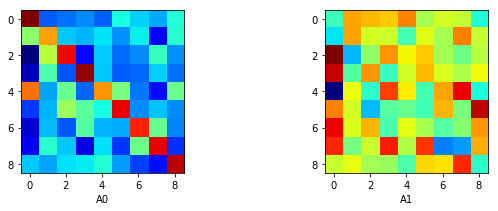

In [15]:
%matplotlib inline 

is_plot=True
normal_A, normal_Q = ar.train(normal_X_train, order = ar_order)

# Feature Vector
feature_vector = np.array(normal_A).flatten()
print ('Feature Vector:')
print (np.array(normal_A))

# Plot AR
if (is_plot):
    fig, ax = plt.subplots(1,len(normal_A), figsize=(10,3))
    for i in range(len(normal_A)):
        if (len(normal_A) > 1):
            ax[i].imshow(normal_A[i], cmap = "jet")
            ax[i].set_xlabel('A'+str(i))
        else:
            ax.imshow(normal_A[i], cmap = "jet")
            ax.set_xlabel('A'+str(i))


#### Test AR

In [ ]:
Y = ar.test(X_test,A)
err = (ar.error(Y,X_test))
print (np.mean(err))

# MRS Videos

### Read Inputs

In [16]:
mrs_cells_files = [
        '/media/narita/Data/Neutrophils/fps_20_frames/2_07052016_Phagocytosis_MRS2578/final'\
                  '/tracking/organized_kalman_output_center_coords.npy',
        '/media/narita/Data/Neutrophils/fps_20_frames/6_07072016_Phagocytosis_MRS2578/final' \
                      '/tracking/organized_kalman_output_center_coords.npy'


]

all_mrs_cells = []
for i in range(len(mrs_cells_files)):
    mrs_input = np.load(mrs_cells_files[i])
    all_mrs_cells.insert(i,mrs_input)

all_mrs_cells = np.vstack(all_mrs_cells) 


### Trajectory Plots

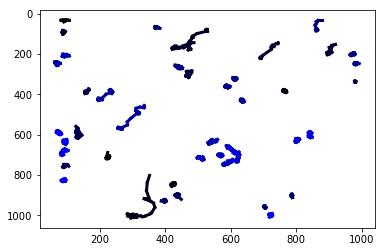

In [17]:
#%matplotlib notebook
plot_trajectory_2D(all_mrs_cells.shape[1],False,all_mrs_cells[:,:,0],all_mrs_cells[:,:,1])


### AR

#### Normalize Input

In [18]:
all_mrs_cells_copy = all_mrs_cells.copy()
all_mrs_cells_copy = np.transpose(all_mrs_cells_copy,(1,0,2))
all_mrs_cells_copy = all_mrs_cells_copy.reshape(all_mrs_cells_copy.shape[0],all_mrs_cells_copy.shape[1]*all_mrs_cells_copy.shape[2])

all_mrs_cells_norm,mrs_norms = normalize(all_mrs_cells_copy,axis=0,return_norm=True)


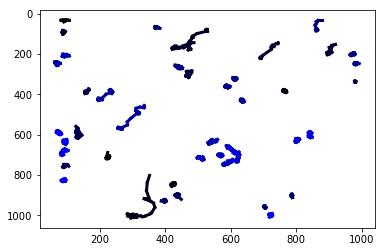

In [19]:
# If needed, plot again
mrs_recon = all_mrs_cells_norm*mrs_norms
mrs_recon = mrs_recon.reshape(all_mrs_cells_norm.shape[0],int(all_mrs_cells_norm.shape[1]/2),2)
mrs_recon = np.transpose(mrs_recon,(1,0,2))
plot_trajectory_2D(mrs_recon.shape[1],False,mrs_recon[:,:,0],mrs_recon[:,:,1])



#### State Space Reduction

In [20]:
mrs_X,mrs_C,mrs_S,mrs_U = ar.state_space(all_mrs_cells_norm.T, pca_components)

#### Variance of components

[90.443892559857332, 3.7030338637594626, 2.5385654428067568, 1.057039025869468, 0.60461103027062491, 0.55501968028802495, 0.43687405057398443, 0.33396220669770854, 0.32700213987665844]


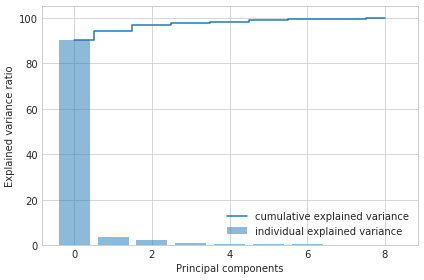

In [21]:
tot = sum(mrs_S)
var_exp = [(i / tot) * 100 for i in sorted(mrs_S, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print ((var_exp))

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

#### Plotting components after PCA

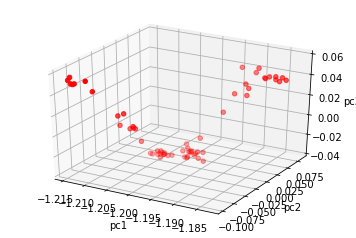

In [22]:
# 3D Plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mrs_X[0,:], mrs_X[1,:], mrs_X[2,:],  c='r', marker='o')
ax.set_xlabel('pc1');ax.set_ylabel('pc2');ax.set_zlabel('pc3');

plt.show()

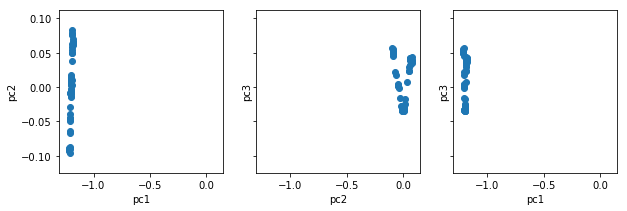

In [23]:
#2D Plot
%matplotlib inline

fig, ax = plt.subplots(1,3, sharey=True, sharex= True, figsize=(10,3))
ax[0].scatter(mrs_X[0,:],mrs_X[1,:]);ax[0].set_xlabel('pc1');ax[0].set_ylabel('pc2')
ax[1].scatter(mrs_X[1,:],mrs_X[2,:]);ax[1].set_xlabel('pc2');ax[1].set_ylabel('pc3')
ax[2].scatter(mrs_X[0,:],mrs_X[2,:]);ax[2].set_xlabel('pc1');ax[2].set_ylabel('pc3')


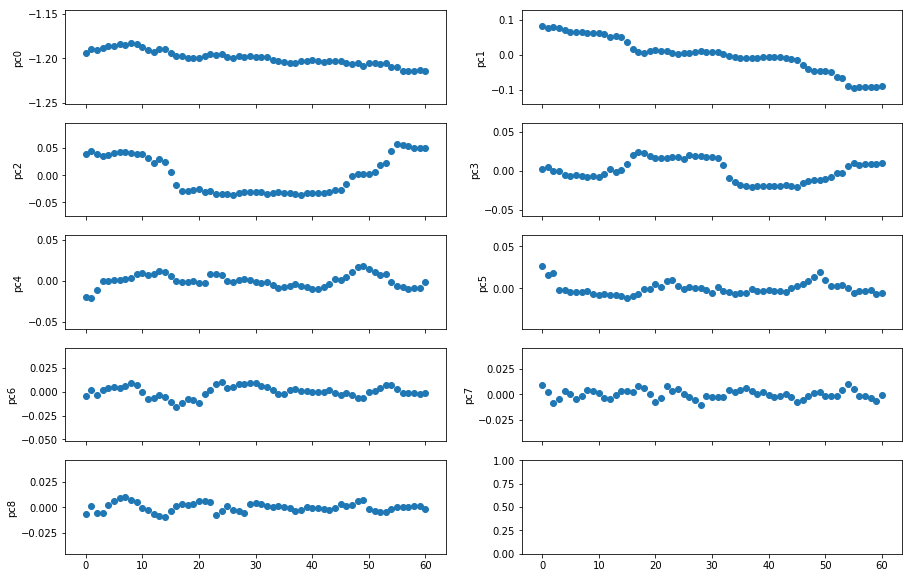

In [24]:
#2D Plot
%matplotlib inline

rows = int((pca_components/2)+(pca_components%2))
cols = 2
fig, ax = plt.subplots(rows,cols,sharex= True, figsize=(15,10))
for i in range(pca_components):
    r = int(i/2)
    c = int(i%2)
    ax[r,c].scatter(range(len(mrs_X[i,:])),mrs_X[i,:]);ax[r,c].set_ylabel('pc'+str(i))


#### AR Train

In [25]:
mrs_X_train = mrs_X[:,:]
#mrs_X_test = mrs_X[:,50:]

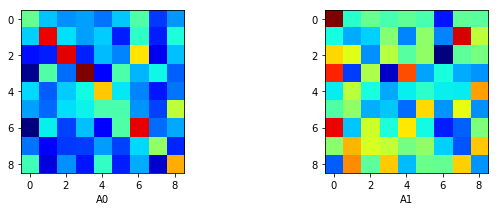

In [26]:
is_plot=True
mrs_A, mrs_Q = ar.train(mrs_X_train, order = ar_order)

# Feature Vector
feature_vector = np.array(mrs_A).flatten()
#print ('Feature Vector:')
#print (np.array(mrs_A))

# Plot AR
if (is_plot):
    fig, ax = plt.subplots(1,len(mrs_A), figsize=(10,3))
    for i in range(len(mrs_A)):
        if (len(mrs_A) > 1):
            ax[i].imshow(mrs_A[i], cmap = "jet")
            ax[i].set_xlabel('A'+str(i))
        else:
            ax.imshow(mrs_A[i], cmap = "jet")
            ax.set_xlabel('A'+str(i))


#### AR Test

In [ ]:
Y = ar.test(mrs_X_test, A)
err = ar.error(Y,mrs_X_test)
np.mean(err)

# Histograms of components of normal, mrs

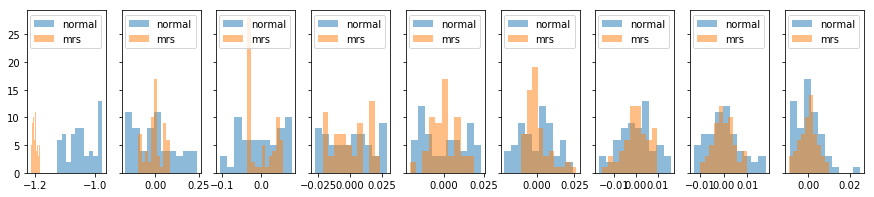

In [27]:
%matplotlib inline
pcs = mrs_X.shape[0]
f, axarr = plt.subplots(1, pcs,sharey=True, figsize=(15,3))

for i in range(pcs):
    axarr[i].hist(normal_X[i,:],bins=10, alpha=0.5, label='normal')
    axarr[i].hist(mrs_X[i,:],bins=10, alpha=0.5, label='mrs')
    axarr[i].legend(loc='upper right')
plt.show()


# Noise covariance matrix Q of normal, mrs

/home/narita/anaconda2/envs/pytorchenv/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


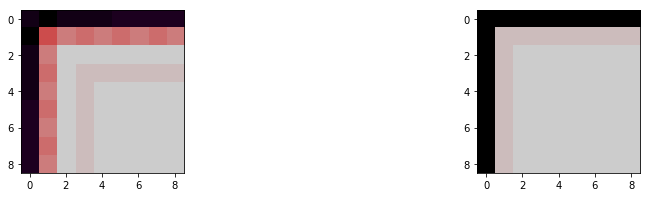

In [28]:
%matplotlib inline

f, axarr = plt.subplots(1, 2,figsize=(15,3))
axarr[0].imshow(normal_Q,cmap='spectral')
axarr[1].imshow(mrs_Q,cmap='spectral')

In [29]:
def get_eigens(z,is_plot=False,is_print=False):
    cov_mat = z
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    if (is_print):
        print('Eigenvectors \n%s' % eig_vecs)
        print('\nEigenvalues \n%s' % eig_vals)

        for ev in eig_vecs:
            np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
        print('Everything ok!')
        print ('')

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    if (is_print):
        #Visually confirm that the list is correctly sorted by decreasing eigenvalues
        print('Eigenvalues in descending order:')
        for i in eig_pairs:
            print(i[0])

    tot = sum(eig_vals)
    var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    print ((var_exp))

    if (is_plot):
        with plt.style.context('seaborn-whitegrid'):
            plt.figure(figsize=(6, 4))

            plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
                    label='individual explained variance')
            plt.step(range(len(var_exp)), cum_var_exp, where='mid',
                     label='cumulative explained variance')
            plt.ylabel('Explained variance ratio')
            plt.xlabel('Principal components')
            plt.legend(loc='best')
            plt.tight_layout()
        plt.show()




Normal
[99.666743112992862, 0.28920166020029509, 0.03343362823989933, 0.0050539425391407248, 0.0021564316904152665, 0.0016631837450673374, 0.00071487368230077619, 0.00061156038393140677, 0.00042160652609435644]


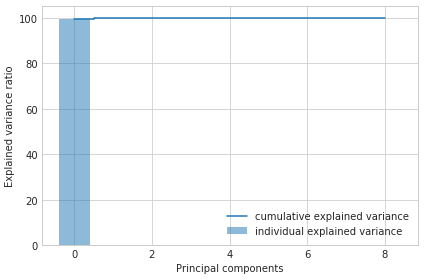


Abnormal
[99.942193172106371, 0.040882411215394772, 0.012895454350457755, 0.0023813110074385859, 0.00076659963012945314, 0.00032885884830589923, 0.00025621622951447424, 0.00018702793664152797, 0.00010894867573825608]


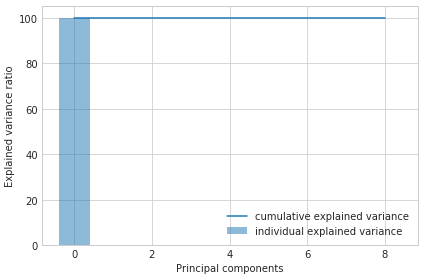

In [30]:
print ('Normal')
get_eigens(normal_Q,is_plot=True)
print ('')

print ('Abnormal')
get_eigens(mrs_Q,is_plot=True)

# Synthesize

### Multi-Step Out-of-Sample Forecast

This forecast randomly selects a starting point and forecasts predict_states time steps ahead in the sequence from the available data used to fit the model.

#### Intialize Vars

In [ ]:
cls = 'mrs'
if (cls == 'normal'):
    input_X = normal_X_train
    A = normal_A
    Q = normal_Q
    C = normal_C
    norm = normal_norms
    

else:
    
    input_X = mrs_X_train
    A = mrs_A
    Q = mrs_Q
    C = mrs_C
    norm = mrs_norms



predict_states = 25

In [ ]:
import random

selected_index = random.randrange(0, 5, 1)
print (selected_index)

X_subsample = input_X[:,selected_index:selected_index+2]
orig_X, predicted_X,orig_predicted,orig_recon = predict(X_subsample,A,predict_states=predict_states)

print (orig_X.shape)
print (predicted_X.shape)
print (orig_predicted.shape)

#### Just making sure that the predictions are from the same subspace

In [ ]:
%matplotlib inline

X_in_copy = input_X.T.copy()
f, axarr = plt.subplots(1, predicted_X.shape[0],figsize=(15,3),sharex=True)
for i in range(predicted_X.shape[0]):
    X_in = X_in_copy[:,i]
    pc = list(predicted_X[i,:])
    axarr[i].hist(X_in,alpha=0.5)
    axarr[i].set_xlabel('component_'+(str(i+1)))
    axarr[i].scatter(pc,np.ones(len(pc)),color='r')

plt.show()


In [ ]:
X_train_copy = input_X.copy()
orig_pixel_space = ar.appearance_space(X_train_copy,C)

orig_image_space = (orig_pixel_space.T * norm).T
orig_image_space = np.reshape(orig_image_space,(int(orig_image_space.shape[0]/2),2,orig_image_space.shape[1]))
orig_image_space = np.transpose(orig_image_space,(0,2,1))

predicted_copy = orig_predicted.copy()
predicted_pixel_space = ar.appearance_space(predicted_copy,C)
predicted_image_space = (predicted_pixel_space.T * norm).T
predicted_image_space = np.reshape(predicted_image_space,(int(predicted_image_space.shape[0]/2),2,predicted_image_space.shape[1]))
predicted_image_space = np.transpose(predicted_image_space,(0,2,1))

frame_num = orig_image_space.shape[1]
is_one = False
currentX = orig_image_space[:,:,0]
currentY = orig_image_space[:,:,1]


cxx = predicted_image_space[:,:,0]
cyy = predicted_image_space[:,:,1]


plot_trajectory_2D(frame_num,is_one,currentX,currentY,cxx,cyy,scatter_plot=True)
plot_trajectory_2D(frame_num,is_one,currentX,currentY,None,None,scatter_plot=True)




In [ ]:
predicted_outputs = predicted_image_space.copy()
path = '/media/narita/Data/Neutrophils/fps_20_frames/average_motion_model' \
                      '/ar_generated_center_coords_'+cls+'_'+str(predict_states)+'.npy'

np.save(path,predicted_outputs)
print (path+' saved!')

### One-Step Out-of-Sample Forecast

A one-step forecast is a forecast of the very next time step in the sequence from the available data used to fit the model.

In [ ]:
total_frames = input_X.shape[1]
selected_index = total_frames - ar_order 
print (selected_index)

X_subsample = input_X[:,selected_index:selected_index+2]
orig_X, predicted_X,orig_predicted,orig_recon = predict(X_subsample,A,predict_states=1)

print (orig_X.shape)
print (predicted_X.shape)
print (orig_predicted.shape)

In [ ]:
X_train_copy = input_X.copy()
orig_pixel_space = ar.appearance_space(X_train_copy,C)

orig_image_space = (orig_pixel_space.T * norm).T
orig_image_space = np.reshape(orig_image_space,(int(orig_image_space.shape[0]/2),2,orig_image_space.shape[1]))
orig_image_space = np.transpose(orig_image_space,(0,2,1))

predicted_copy = orig_predicted.copy()
predicted_pixel_space = ar.appearance_space(predicted_copy,C)
predicted_image_space = (predicted_pixel_space.T * norm).T
predicted_image_space = np.reshape(predicted_image_space,(int(predicted_image_space.shape[0]/2),2,predicted_image_space.shape[1]))
predicted_image_space = np.transpose(predicted_image_space,(0,2,1))

frame_num = orig_image_space.shape[1]
is_one = False
currentX = orig_image_space[:,:,0]
currentY = orig_image_space[:,:,1]


cxx = predicted_image_space[:,:,0]
cyy = predicted_image_space[:,:,1]


plot_trajectory_2D(frame_num,is_one,currentX,currentY,cxx,cyy,scatter_plot=True)
plot_trajectory_2D(frame_num,is_one,currentX,currentY,None,None,scatter_plot=True)




# Grid Search AR

In [31]:
# evaluate an AR model for a given order (o)
from sklearn.metrics import mean_squared_error

def evaluate_ar_model(X, split, ar_order):
    try:
        # prepare training dataset
        train_size = int((X.shape[1]) * split)
        train, test = X[:,0:train_size], X[:,train_size:]
        
        # make predictions
        A, Q = ar.train(train, order = ar_order)
        yhat = ar.test(test,A)
        predictions =[]
        
        for t in range((test.shape[1])):
            A, Q = ar.train(train, order = ar_order)
            orig_X, next_X, Xnext, Xnext_mean = predict(train[:,-ar_order:],A,predict_states=1)
            predictions.append(next_X.flatten())
            z = test[:,t].reshape((test.shape[0],1))
            train = np.concatenate((train,z),axis=1)
            
        # calculate out of sample error
        error = mean_squared_error(yhat, test)
    except:
         print ("Unexpected error:", sys.exc_info())
    return (error)


In [32]:
# evaluate combinations of q, d values for an AR model
def evaluate_models(dataset, q_values=range(1,10), d_values=range(2,10)):
    best_score, best_cfg = float("inf"), None
    split = 0.8
    for q in q_values:
        normal_X,normal_C,normal_S,normal_U = ar.state_space(dataset.T,q)
        for d in d_values:
            order = (q,d)
            try:
                mse = evaluate_ar_model(normal_X,split, d)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                    print('AR%s MSE=%.5f' % (order,mse))
            except:
                    continue
    print('Best AR%s MSE=%.5f' % (best_cfg, best_score))


In [33]:
evaluate_models(all_normal_cells_norm)

AR(1, 2) MSE=0.96385
AR(2, 2) MSE=0.32108
AR(2, 3) MSE=0.32108
AR(3, 2) MSE=0.15589
AR(3, 4) MSE=0.15589
AR(4, 2) MSE=0.08925
AR(4, 3) MSE=0.08924
AR(4, 4) MSE=0.08923
AR(5, 2) MSE=0.05774
AR(5, 3) MSE=0.05774
AR(6, 2) MSE=0.04046
AR(7, 2) MSE=0.02969
AR(8, 2) MSE=0.02293
AR(9, 2) MSE=0.01812
Best AR(9, 2) MSE=0.01812


In [34]:
evaluate_models(all_mrs_cells_norm)

AR(1, 2) MSE=1.46347
AR(2, 2) MSE=0.41192
AR(2, 6) MSE=0.41192
AR(2, 7) MSE=0.41191
AR(2, 9) MSE=0.41191
AR(3, 2) MSE=0.17432
AR(3, 3) MSE=0.17425
AR(4, 2) MSE=0.09831
AR(5, 2) MSE=0.06280
AR(6, 2) MSE=0.04376
AR(7, 2) MSE=0.03271
AR(7, 9) MSE=0.03262
AR(8, 2) MSE=0.02505
AR(8, 9) MSE=0.02476
AR(9, 2) MSE=0.01983
AR(9, 9) MSE=0.01956
Best AR(9, 9) MSE=0.01956
